In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from numba import njit, jit, int64, float32, prange

## Basics

### Define the game

In [2]:
nb_actions_1 = 2  # TODO make code able to handle nb_actions > 2
nb_actions_2 = 2
#payouts for player 1 and 2 in each state
payouts_1 = np.ones((nb_actions_1, nb_actions_2))
payouts_2 = np.ones((nb_actions_1, nb_actions_2))
payouts_1[0, 0] = 3
payouts_2[0, 0] = 3
payouts_1[0, 1] = 0
payouts_2[0, 1] = 4
payouts_1[1, 0] = 4
payouts_2[1, 0] = 0
payouts_1[1, 1] = 1
payouts_2[1, 1] = 1

@jit#t(int32(int32, int32))
def get_payouts(action_1 : int, action_2 : int):
    # params: actions of both players
    # return: payouts of both players
    # rtype: Vector{Float64}
    return payouts_1[action_1, action_2], payouts_2[action_1, action_2]





### Get actions

In [3]:
@njit
def get_strategy(random_strategy : np.ndarray):
    # params: random strategy
    # return: a realisation of the random strategy
    # rtype: Matrix{Int}
    shape = random_strategy.shape
    strategy = np.zeros((shape[0], shape[1]), dtype=int64)
    for i in prange(shape[0]):
        for j in prange(shape[1]):
            if np.random.rand() < random_strategy[i, j, 0]:
                strategy[i, j] = 0
            else:
                strategy[i, j] = 1
                
    return strategy

def get_action(strategy : np.ndarray, state : np.ndarray):
    # params: stategy and state
    # return: action taken according to strategy in this state
    # rtype: Int
    if len(strategy.shape) == 2:
        return strategy[state[0], state[1]]
    
    if len(strategy.shape) == 3:
        # return: action taken according to a realisation of the random strategy in this state
        return get_strategy(strategy)[state[0], state[1]]
    
    raise("The strategy doesn't have correct dimensions")

@njit
def get_all_strategies():
    # get them as probability of playing action 1, 2
    # return: an array of the 16 pure strategies (as random strategies)
    # rtype: Array{Float64, 4}
    strategies = np.ones((16, 2, 2, 2), dtype=int64)
    for i in range(16):
        strategies[i, 0, 0, 0] = np.floor(i/8)
        strategies[i, 0, 0, 1] = 1 - strategies[i, 0, 0, 0]
        strategies[i, 0, 1, 0] = np.floor((i%8)/4)
        strategies[i, 0, 1, 1] = 1 - strategies[i, 0, 1, 0]
        strategies[i, 1, 0, 0] = np.floor((i%4)/2)
        strategies[i, 1, 0, 1] = 1 - strategies[i, 1, 0, 0]
        strategies[i, 1, 1, 0] = i%2
        strategies[i, 1, 1, 1] = 1 - strategies[i, 1, 1, 0]
    
    return strategies

@njit
def get_strategy_from_mixture(mixture):
    cumsum_probas = np.cumsum(mixture)
    random_val = np.random.rand()
    indexes = cumsum_probas > random_val
    all_strats = get_all_strategies()
    return get_strategy(all_strats[np.argmax(indexes), :, :, :])

### Get values

In [4]:
@njit
def get_value1(state, strategy_1, strategy_2, nb_tries, nb_iterations):
    # params: starting state, two pure strategies
    # return: mean values of the cycle TODO(explain this), starting from state
    # rtype: Vector{Float64}
    new_state = state
    total_payout_1 = 0.
    total_payout_2 = 0.

    for i in range(nb_iterations):
        action_1 = strategy_1[new_state[0], new_state[1]]
        action_2 = strategy_2[new_state[0], new_state[1]]
        new_state = np.array([action_1, action_2])
        payouts = get_payouts(action_1, action_2)
        if i>4:
            total_payout_1 += payouts[0]
            total_payout_2 += payouts[1]
    
    total_payout_1 /= ((nb_iterations-4))
    total_payout_2 /= ((nb_iterations-4))
    
    return total_payout_1, total_payout_2

@njit
def get_value2(state, strategy_1, rnd_strat_2, nb_tries, nb_iterations):
    # params: starting state, one pure and one random strategy
    # return: mean value of game after many iterations, starting from state
    # rtype: Vector{Float64}
    total_payout_1 = 0.
    total_payout_2 = 0.
    for t in prange(nb_tries):
        new_state = state.copy()
        
        for i in range(nb_iterations):
            action_1 = strategy_1[new_state[0], new_state[1]]
            action_2 = get_strategy(rnd_strat_2)[new_state[0], new_state[1]]
            new_state = np.array([action_1, action_2])
            payouts = get_payouts(action_1, action_2)
            if i>4:
                total_payout_1 += payouts[0]
                total_payout_2 += payouts[1]
    total_payout_1 /= ((nb_iterations-4) * nb_tries)
    total_payout_2 /= ((nb_iterations-4) * nb_tries)
    return total_payout_1, total_payout_2

@njit
def get_value3(state, rnd_strat_1, strategy_2, nb_tries, nb_iterations):
    # params: starting state, one pure and one random strategy
    # return: mean value of game after many iterations, starting from state
    # rtype: Vector{Float64}
    total_payout_1 = 0.
    total_payout_2 = 0.
    
    for t in prange(nb_tries):
        new_state = state.copy()
        for i in range(nb_iterations):
            action_1 = get_strategy(rnd_strat_1)[new_state[0], new_state[1]]
            action_2 = strategy_2[new_state[0], new_state[1]]
            new_state = np.array([action_1, action_2])
            payouts = get_payouts(action_1, action_2)
            if i>4:
                total_payout_1 += payouts[0]
                total_payout_2 += payouts[1]
    
    total_payout_1 /= ((nb_iterations-4) * nb_tries)
    total_payout_2 /= ((nb_iterations-4) * nb_tries)
    
    return total_payout_1, total_payout_2

@njit
def get_value4(state, rnd_strat_1, rnd_strat_2, nb_tries, nb_iterations):
    # params: starting state, two random strategies
    # return: mean value of game after many iterations, starting from state
    # rtype: Vector{Float64}
    total_payout_1 = 0.
    total_payout_2 = 0.
    for t in prange(nb_tries):
        new_state = state.copy()
        for i in range(nb_iterations):
            action_1 = get_strategy(rnd_strat_1)[new_state[0], new_state[1]]
            action_2 = get_strategy(rnd_strat_2)[new_state[0], new_state[1]]
            new_state = np.array([action_1, action_2])
            payouts = get_payouts(action_1, action_2)
            if i>4:
                total_payout_1 += payouts[0]
                total_payout_2 += payouts[1]
    
    total_payout_1 /= ((nb_iterations-4) * nb_tries)
    total_payout_2 /= ((nb_iterations-4) * nb_tries)
    return total_payout_1, total_payout_2

def get_value(state, strategy_1, strategy_2, nb_tries=20, nb_iterations=20):
    state = np.array(state)
    if len(strategy_1.shape) == 2:
        if len(strategy_2.shape) == 2:
            return get_value1(state, strategy_1, strategy_2, nb_tries, nb_iterations)
        if len(strategy_2.shape) == 3:
            return get_value2(state, strategy_1, strategy_2, nb_tries, nb_iterations)
    if len(strategy_1.shape) == 3:
        if len(strategy_2.shape) == 2:
            return get_value3(state, strategy_1, strategy_2, nb_tries, nb_iterations)
        if len(strategy_2.shape) == 3:
            return get_value4(state, strategy_1, strategy_2, nb_tries, nb_iterations)


strategy_1 = np.ones((nb_actions_1, nb_actions_2), dtype=int)
strategy_2 = np.ones((nb_actions_1, nb_actions_2), dtype=int)
strategy_1[0, 0] = 0
strategy_1[0, 1] = 1
strategy_1[1, 0] = 1
strategy_1[1, 1] = 1

strategy_2[0, 0] = 0
strategy_2[0, 1] = 1
strategy_2[1, 0] = 1
strategy_2[1, 1] = 1

print(get_value([1, 1], strategy_1, strategy_2))

def get_value_in_all_states(strategy_1, strategy_2):
    values = np.zeros((nb_actions_1, nb_actions_2, 2))
    for i in range(nb_actions_1):
        for j in range(nb_actions_2):
            value = get_value([i, j], strategy_1, strategy_2)
            values[i, j, 0] = value[0]
            values[i, j, 1] = value[1]
    return values

print(get_value_in_all_states(strategy_1, strategy_2))

(0.9375, 0.9375)
[[[2.8125 2.8125]
  [0.9375 0.9375]]

 [[0.9375 0.9375]
  [0.9375 0.9375]]]


## Algorithms

In [5]:
all_strategies = get_all_strategies()
# print(all_strategies[1])
print('Strategies for player 1')
print('Tit for tat : \n', get_strategy(all_strategies[10])) # Tit for tat
print('Always defect : \n', get_strategy(all_strategies[0])) # Always defect
print('Always cooperate : \n', get_strategy(all_strategies[15])) # Always cooperate
print('Trigger trim : \n', get_strategy(all_strategies[8])) # Trigger trim

print('Strategies for player 2')
print('Tit for tat : \n', get_strategy(all_strategies[10]).T) # Tit for tat
print('Always defect : \n', get_strategy(all_strategies[0]).T) # Always defect
print('Always cooperate : \n', get_strategy(all_strategies[15]).T) # Always cooperate
print('Trigger trim : \n', get_strategy(all_strategies[8]).T) # Trigger trim

Strategies for player 1
Tit for tat : 
 [[0 1]
 [0 1]]
Always defect : 
 [[1 1]
 [1 1]]
Always cooperate : 
 [[0 0]
 [0 0]]
Trigger trim : 
 [[0 1]
 [1 1]]
Strategies for player 2
Tit for tat : 
 [[0 0]
 [1 1]]
Always defect : 
 [[1 1]
 [1 1]]
Always cooperate : 
 [[0 0]
 [0 0]]
Trigger trim : 
 [[0 1]
 [1 1]]


First, we define for all $i$
$$
\tilde{x}_i = \exp(\eta(x_i - \max_{j\in [d]} x_j))
$$
The custom logit for $x\in \mathbb R^d$ is defined as
$$
y_i = \frac{\sum_{k=1}^i\tilde{x}_k}{\sum_{k=1}^d\tilde{x}_k}
$$
The fraction is a normalized cumulative sum.
The selected index is 
$$
\argmax_i\ (\mathbb{I}(y_i > U))_{i\in[d]}
$$
with $U$ a random variable following uniform distribution on $[0,1]$.
So we define the function $L$
$$
L(x) = 
\argmax_i\ (\mathbb{I}(y_i > U))_{i\in[d]}
$$

In [6]:
@njit
def custom_logit(array, pivot):
    exp_arr = np.exp(array - np.max(array))
    cumsum_normed_exp = np.cumsum(exp_arr / np.sum(exp_arr))
    indexes = cumsum_normed_exp > pivot
    return np.argmax(indexes) # works since argmax returns the first highest value

def get_learned_strategy(state_frequencies, id, adv_strategy, previous_means, t, pivot,
                         eta = lambda t : np.sqrt(t)):
    # params:
    #    state_frequencies:
    #    id: equal to 1 if player 1, 2 if player 2
    #    adv_strategy: latext strategy of the other player
    #    previous_means:
    #    t: current stage
    # return: a strategy, updated means of all pure strategies
    # rtype: (Matrix{Int}, Vector{Float64})
    future_reward_per_strategy = np.zeros(16)
    for strategy_idx in prange(16):
        strategy_candidate = get_strategy(all_strategies[strategy_idx, :, :, :])
        if id==0:
            all_values = get_value_in_all_states(strategy_candidate, adv_strategy)
        else:
            all_values = get_value_in_all_states(adv_strategy, strategy_candidate)
        
        future_reward_per_strategy[strategy_idx] = np.sum(all_values[:, :, id] * state_frequencies)
    
    means = previous_means + (future_reward_per_strategy - previous_means) / (t+1)
    chosen_strategy_idx = custom_logit((eta(t) * means), pivot)
    strategy_rand = all_strategies[chosen_strategy_idx, :, :, :]
    strategy = get_strategy(strategy_rand)
    #println(strategy_rand)
    return strategy, means

def get_learned_strategy_emp(state_frequencies, id, adv_strategy, previous_means, t, pivot,
                         eta = lambda t : np.sqrt(t)):
    # params:
    #    state_frequencies:
    #    id: equal to 1 if player 1, 2 if player 2
    #    adv_strategy: empirical mixed strategy of the other player
    #    t: current stage
    # return: a strategy, scores of  all pure strategies
    # rtype: (Matrix{Int}, Vector{Float64})
    future_reward_per_strategy = np.zeros(16)
    for strategy_idx in prange(16):
        strategy_candidate = get_strategy(all_strategies[strategy_idx, :, :, :])
        if id==0:
            all_values = get_value_in_all_states(strategy_candidate, adv_strategy)
        else:
            all_values = get_value_in_all_states(adv_strategy, strategy_candidate)

        future_reward_per_strategy[strategy_idx] = np.sum(all_values[:, :, id] * state_frequencies)
    
    means = previous_means + (future_reward_per_strategy - previous_means) / (t+1)
    chosen_strategy_idx = custom_logit((eta(t) * future_reward_per_strategy), pivot)
    strategy = get_strategy(all_strategies[chosen_strategy_idx, :, :, :])
    return strategy, future_reward_per_strategy


def get_learned_strategy_half_memory(state_frequencies, id, adv_strategy, previous_means, t):
    # params:
    #    state_frequencies:
    #    id: equal to 1 if player 1, 2 if player 2
    #    adv_strategy: latext strategy of the other player
    #    previous_means:
    #    t: current stage
    # return: a strategy, updated means of all pure strategies
    # rtype: (Matrix{Int}, Vector{Float64})
    future_reward_per_strategy = np.zeros(4)
    strategies = np.zeros(4)
    for strategy_idx in range(4):
        if id==0:
            strategies = [1, 6, 11, 16]
        else:
            strategies = [1, 4, 13, 16]

        s_idx = strategies[strategy_idx]
        strategy_candidate = get_strategy(all_strategies[s_idx, :, :, :])
        if id==0:
            all_values = get_value_in_all_states(strategy_candidate, adv_strategy)
        else:
            all_values = get_value_in_all_states(adv_strategy, strategy_candidate)
            
        future_reward_per_strategy[strategy_idx] = sum(all_values[:, :, id] * state_frequencies)
    
    means = previous_means + (future_reward_per_strategy - previous_means) / t
    chosen_strategy_idx = strategies[custom_logit((np.sqrt(t) * means))]
    strategy_rand = all_strategies[chosen_strategy_idx, :, :, :]
    strategy = get_strategy(strategy_rand)
    #println(chosen_strategy_idx, strategy)
    return strategy, means



## Some simulations

### Preliminaries

In [7]:
get_value_in_all_states(
    strategy_1,
    0.4 * all_strategies[12, :, :, :] + 0.6 * all_strategies[14, :, :, :])

array([[[2.8125  , 2.8125  ],
        [0.975   , 0.925   ]],

       [[0.946875, 0.934375],
        [0.9375  , 0.9375  ]]])

In [8]:
all_values = np.zeros((16, 16, 4))
for strat_rnd in range(16):
    for strat_rnd_2 in range(16):
        #println(strat_rnd)
        #println(get_strategy(all_strat[strat_rnd, :, :, :]))
        for i in range(2):
            all_values[strat_rnd, strat_rnd_2, i] = get_value_in_all_states(
                get_strategy(all_strategies[strat_rnd, :, :, :]),
                get_strategy(all_strategies[strat_rnd_2, :, :, :]))[0, i, 0]
        
        for i in range(2):
            all_values[strat_rnd, strat_rnd_2, i+2] = get_value_in_all_states(
                get_strategy(all_strategies[strat_rnd, :, :, :]),
                get_strategy(all_strategies[strat_rnd_2, :, :, :]))[1, i, 0]
            
is_good_strategy = np.zeros((16, 16, 4))
strat_good = np.zeros((16, 16))

for i in range(16):
    for j in range(16):
        for s in range(4):
            is_good_strategy[i, j, s] = (
                np.max(all_values[:, j, s]) == all_values[i, j, s])
        strat_good[i, j] = np.prod(is_good_strategy[i, j, :])
        
value_matrix = np.sum(all_values[:, :, :], axis = 2)#round(sum(all_values[:, :, :],dims = 3), digits = 1)
print(strat_good)
print(value_matrix)
print(np.prod(value_matrix[:, :] - value_matrix[10,:] >= 0, axis=0))
print(sum(strat_good))  # number of good strategies for each j

[[1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]]
[[ 3.75    9.5625  6.5625 15.      3.75    9.375   9.375  15.      3.75
   9.375   9.375  15.      3.75    9.1875 12.1875 15.    ]
 [ 1.8125  7.625   5.125   9.4375  6.25    7.5    15

In [9]:
#find equilibrium : i is best strategy against j and j is best against i
is_eq = strat_good * strat_good.T
print(is_eq)
print(all_values[:, :, 2] * is_eq)

[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.9375 0.     3.75   0.     0.     0.     0.     0.     0.     0.
  3.75   0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  

In [10]:
def render_results(means1, means2, state_appearances, all_payouts, all_states):
    # plt.plot(np.cumsum(all_payouts[:, 0]), label='player 0')
    # plt.plot(np.cumsum(all_payouts[:, 1]), label='player 1')
    # plt.title('Cummulative rewards')
    # plt.legend()
    # plt.show()
    
    payout_mean_1 = np.cumsum(all_payouts[:, 0]) / np.cumsum(np.ones(len(all_payouts)))
    payout_mean_2 = np.cumsum(all_payouts[:, 1]) / np.cumsum(np.ones(len(all_payouts)))
    plt.plot(payout_mean_1, label='player 0')
    plt.plot(payout_mean_2, label='player 1')
    plt.title('Mean rewards')
    plt.legend()
    plt.show()
    
    plt.plot(all_payouts[:, 0], label='player 0')
    plt.plot(all_payouts[:, 1], label='player 1')
    plt.title('Rewards per iteration')
    plt.legend()
    plt.show()
    
    # plt.imshow(state_apearences)#, interpolation='nearest')
    ax = sns.heatmap(state_appearances/np.sum(state_appearances), cmap='crest', linewidth=0.5, annot=True)
    plt.title('Appearance rate per state')
    plt.show()

### Simulation 1
We begin with "always defect" strategies for both players

In [11]:
def simulation(
    strategy_1 = None, 
    strategy_2 = None, 
    nb_games=1, 
    game_length = 1000, 
    initial_state = [0,1],
    rng_state = None,
    ):
    
    if rng_state is not None:
        np.random.set_state(rng_state)
    else:
        np.random.seed(None)
        rng_state = np.random.get_state()
    
    # print('RNG seed : ', rng_state[1][0])
    
    # all_strategies = get_all_strategies()
    fixed_strat1 = True
    fixed_strat2 = True
    
    means1 = np.zeros(16)
    means2 = np.zeros(16)
    #means1 = zeros(4)
    #means2 = zeros(4)
    payout_mean_1 = 0
    payout_mean_2 = 0
    for _ in (range(nb_games)):
        state = initial_state
        #state = [rand(1:2), rand(1:2)]
        state_appearances = np.zeros((nb_actions_1, nb_actions_2))
        state_appearances[state[0], state[1]] = 1
        #random_strategy_2 = 0.4 * all_strategies[16, :, :, :] + 0.6 * all_strategies[3, :, :, :]
        # random_strategy_2 = np.ones((2, 2, 2))
        # # [i, j, s] : action1, action2, next_action
        # random_strategy_2[0, 0, 0] = 0
        # random_strategy_2[0, 0, 1] = 1
        # random_strategy_2[0, 1, 0] = 0
        # random_strategy_2[0, 1, 1] = 1
        # random_strategy_2[1, 0, 0] = 0
        # random_strategy_2[1, 0, 1] = 1
        # random_strategy_2[1, 1, 0] = 0
        # random_strategy_2[1, 1, 1] = 1
        if strategy_2 is None:
            idx1 = np.random.randint(16)
            strategy_2 = get_strategy(all_strategies[idx1, :, :, :])
            fixed_strat2 = False
        # print(strategy_2)
        if strategy_1 is None:
            idx2 = np.random.randint(16)
            strategy_1 = get_strategy(all_strategies[idx2, :, :, :])
            fixed_strat1 = False
        
        # print(idx1, idx2)
        # rnd_strategy_1_emp = 0.5 * np.ones((2, 2, 2))
        # rnd_strategy_2_emp = 0.5 * np.ones((2, 2, 2))
        all_payouts = np.zeros((game_length, 2))
        all_states = np.ones((game_length, 2))
        means1 = np.zeros(16)
        means2 = np.zeros(16)
        #means1 = zeros(4)
        #means2 = zeros(4)
        for i in tqdm(range(game_length)):
            action_1 = get_action(strategy_1, state)
            action_2 = get_action(strategy_2, state)
            payouts = get_payouts(action_1, action_2)
            all_payouts[i, 0] = payouts[0]
            all_payouts[i, 1] = payouts[1]
            state_appearances[action_1, action_2] += 1
            # state_frequencies = state_appearances / sum(state_appearances)
            state_frequencies = np.ones((2, 2)) / 4
            if not fixed_strat1:
                pivot = np.random.rand()
                strategy_1, means1 = get_learned_strategy(#_half_memory(
                    state_frequencies, 0, strategy_2, means1, i, pivot)
            #strategy_1, means1 = get_learned_strategy_emp(
            #    state_frequencies, 1, rnd_strategy_2_emp, i)
            if not fixed_strat2:
                pivot = np.random.rand()
                strategy_2, means2 = get_learned_strategy(#_half_memory(
                    state_frequencies, 1, strategy_1, means2, i, pivot)
                
            state = [action_1, action_2]
            all_states[i, 0] = action_1
            all_states[i, 1] = action_2

        payout_mean_1 = np.cumsum(all_payouts[:, 0]) / np.cumsum(np.ones(game_length))
        payout_mean_2 = np.cumsum(all_payouts[:, 1]) / np.cumsum(np.ones(game_length))
        # print(strategy_1)
        # print(strategy_2)
        # print(state_appearances)
        # print(means1)
        # array = np.sqrt(game_length) * means1
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        # array = np.sqrt(game_length) * means2
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        
    return means1, means2, state_appearances, all_payouts, all_states, rng_state


Here, we extract some failures and store them

In [ ]:
import pickle
i = 7
for _ in range(100):
    *results, rng_state = simulation(game_length=1000)
    treason_rate = results[2][1,1]/np.sum(results[2])
    if treason_rate > 0.4:
        print('failure at ', i)
        print('treason_rate : ', treason_rate)
        with open(f'./failures/failure_{i}.pickle', 'wb') as f:
            pickle.dump(rng_state, f)
        i += 1
        
render_results(*results)

In [ ]:
with open('./failures/failure_6.pickle', 'rb') as f:
    rng_s = pickle.load(f)

100%|██████████| 10000/10000 [00:03<00:00, 2732.95it/s]


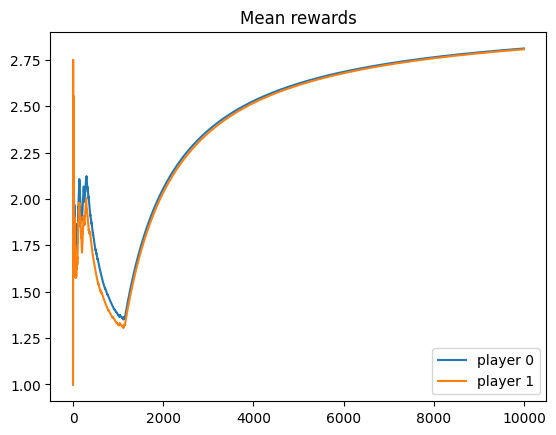

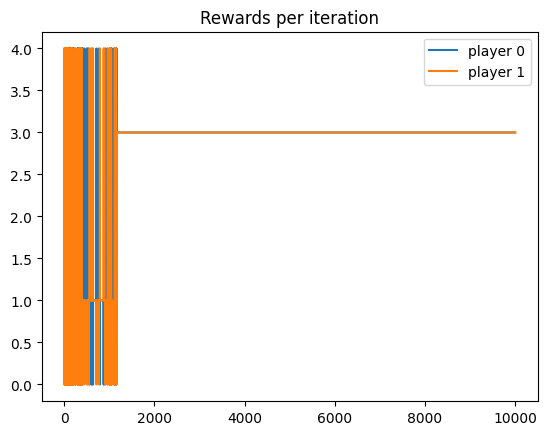

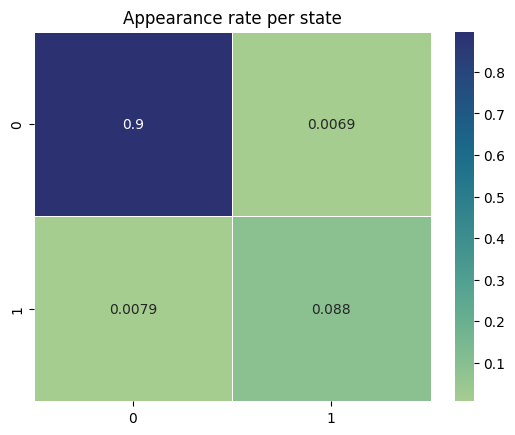

In [ ]:
*results, rng_st = simulation(game_length=10_000, rng_state=rng_s)
render_results(*results)

### Simulation 2 (against tit for tat)

100%|██████████| 1000/1000 [00:00<00:00, 5232.70it/s]


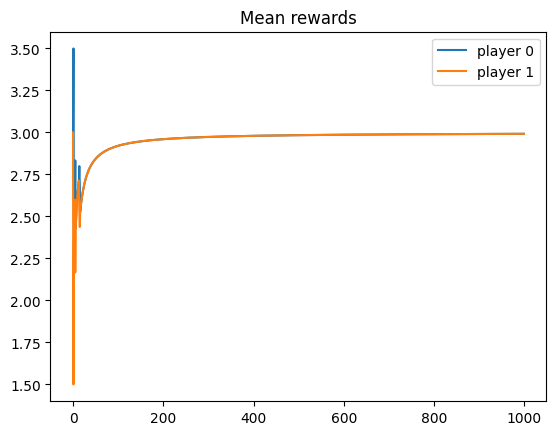

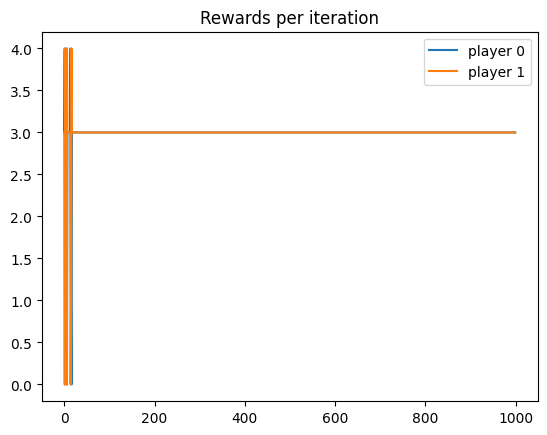

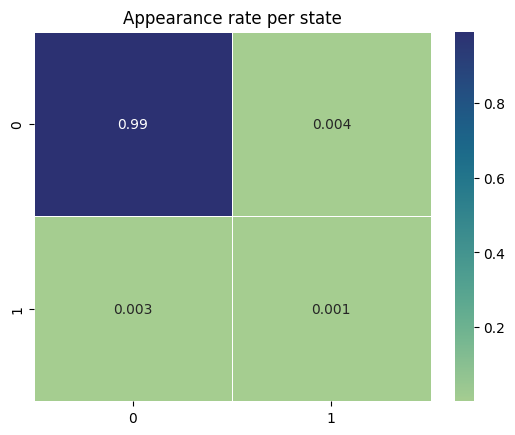

In [ ]:
*results2, _ = simulation(strategy_2= get_strategy(all_strategies[12]))
render_results(*results2)

100%|██████████| 1000/1000 [00:00<00:00, 5102.85it/s]


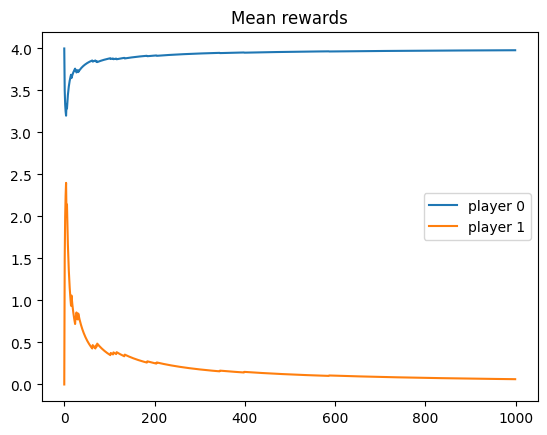

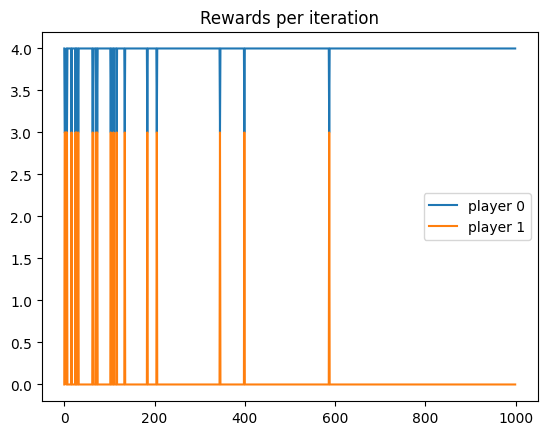

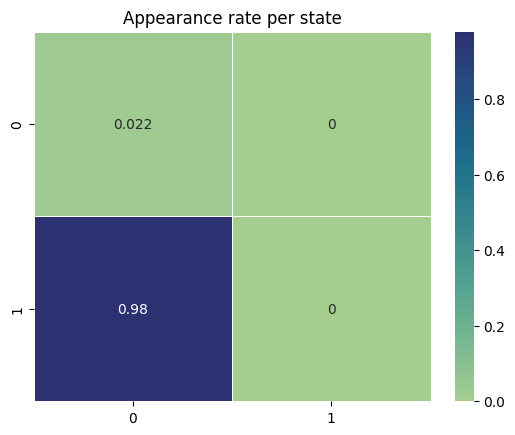

In [ ]:
*results3, _ = simulation(strategy_2= get_strategy(all_strategies[10]), initial_state=[0,0])
render_results(*results3)

100%|██████████| 1000/1000 [00:00<00:00, 4801.35it/s]


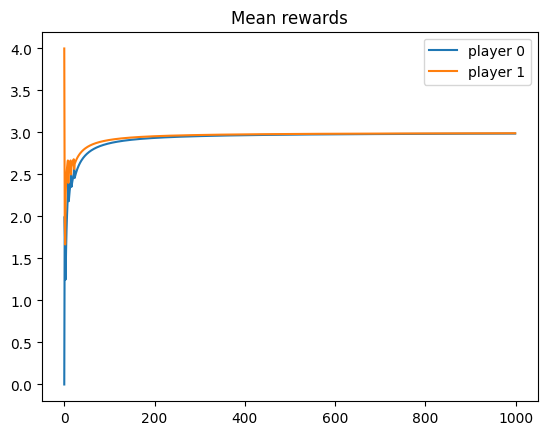

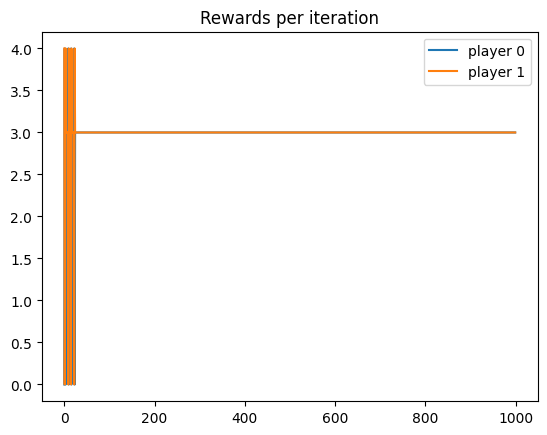

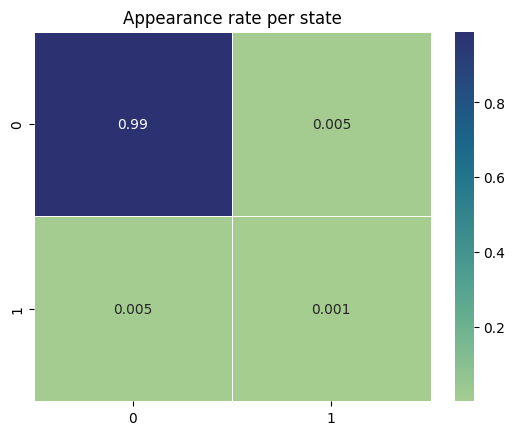

In [ ]:
*results3, _ = simulation(strategy_2= get_strategy(all_strategies[12]), initial_state=[1,0])
render_results(*results3)

## Problem
In the algorithm, we assume that we know the other player's strategy which is not the case in the real life. A natural choice is to estimate the adversary's strategy.

In [21]:
def simulation_w_estimation(
    strategy_1 = None, 
    strategy_2 = None, 
    nb_games=1, 
    game_length = 1000, 
    initial_state = [0,1],
    rng_state = None,
    ):
    
    if rng_state is not None:
        np.random.set_state(rng_state)
    else:
        np.random.seed(None)
        rng_state = np.random.get_state()
    
    # all_strategies = get_all_strategies()
    fixed_strat1 = True
    fixed_strat2 = True
    

    #means1 = zeros(4)
    #means2 = zeros(4)
    payout_mean_1 = 0
    payout_mean_2 = 0
    for _ in range(nb_games):
        state = initial_state.copy()
        
        state_frequencies = np.ones((2, 2)) / 4
        action_state = np.zeros((2, 2, 2, 2))
        means1 = np.zeros(16)
        means2 = np.zeros(16)
    
        #state = [rand(1:2), rand(1:2)]
        state_appearances = np.zeros((nb_actions_1, nb_actions_2))
        state_appearances[state[0], state[1]] = 1
        #random_strategy_2 = 0.4 * all_strategies[16, :, :, :] + 0.6 * all_strategies[3, :, :, :]
        # random_strategy_2 = np.ones((2, 2, 2))
        # # [i, j, s] : action1, action2, next_action
        # random_strategy_2[0, 0, 0] = 0
        # random_strategy_2[0, 0, 1] = 1
        # random_strategy_2[0, 1, 0] = 0
        # random_strategy_2[0, 1, 1] = 1
        # random_strategy_2[1, 0, 0] = 0
        # random_strategy_2[1, 0, 1] = 1
        # random_strategy_2[1, 1, 0] = 0
        # random_strategy_2[1, 1, 1] = 1
        if strategy_2 is None:
            strategy_2 = get_strategy(all_strategies[0, :, :, :])
            fixed_strat2 = False
        # print(strategy_2)
        if strategy_1 is None:
            strategy_1 = get_strategy(all_strategies[0, :, :, :])
            fixed_strat1 = False
            
        rnd_strategy_1_emp = 0.5 * np.ones((2, 2, 2))
        rnd_strategy_2_emp = 0.5 * np.ones((2, 2, 2))
        all_payouts = np.zeros((game_length, 2))
        all_states = np.ones((game_length, 2))
        means1 = np.zeros(16)
        means2 = np.zeros(16)
        #means1 = zeros(4)
        #means2 = zeros(4)
        for i in tqdm(range(game_length)):
            action_1 = get_action(strategy_1, state)
            action_2 = get_action(strategy_2, state)
            payouts = get_payouts(action_1, action_2)
            all_payouts[i, 0] = payouts[0]
            all_payouts[i, 1] = payouts[1]
            action_state[0, state[0], state[1], action_1] += 1
            action_state[1, state[0], state[1], action_2] += 1
            state_appearances[action_1, action_2] += 1
            # state_frequencies = state_appearances / np.sum(state_appearances)
            if not fixed_strat1:
                pivot = np.random.rand()
                strategy_1, means1 = get_learned_strategy_emp(
                    state_frequencies, 0, rnd_strategy_2_emp, means1, i, pivot)
                
            if not fixed_strat2:
                pivot = np.random.rand()
                strategy_2, means2 = get_learned_strategy_emp(
                   state_frequencies, 1, rnd_strategy_1_emp, means2, i, pivot)
            #strategy_2 = get_strategy(random_strategy_2)
            # full info on the strategies
            #for a=1:2
            #    for b=1:2
            #        rnd_strategy_1_emp[a, b, 1] = (
            #            rnd_strategy_1_emp[a, b, 1]
            #            + (1*(strategy_1[a, b] == 1) - rnd_strategy_1_emp[a,b,1])/(i+1)
            #        )
            #        rnd_strategy_2_emp[a, b, 1] = (
            #            rnd_strategy_2_emp[a, b, 1]
            #            + (1*(strategy_2[a, b] == 1) - rnd_strategy_2_emp[a,b,1])/(i+1)
            #        )
            #    end
            #end
            
            # bandit info
            rnd_strategy_1_emp[state[0], state[1], 0] = (
                action_state[0, state[0], state[1], 0] / np.sum(action_state[0, state[0], state[1]])
                # rnd_strategy_1_emp[state[0], state[1], 0]
                # + (1*(action_1 == 0) - rnd_strategy_1_emp[state[0], state[1], 0])/state_frequencies[state[0], state[1]]
            )
            rnd_strategy_1_emp[state[0], state[1], 1] = (
                1-rnd_strategy_1_emp[state[0], state[1], 0]
                # + (1*(action_1 == 1) - rnd_strategy_1_emp[state[0], state[1], 1])/state_frequencies[state[0], state[1]]
            )
            
            rnd_strategy_2_emp[state[0], state[1], 0] = (
                action_state[1, state[0], state[1], 0] / np.sum(action_state[1, state[0], state[1]])
                # + (1*(action_2 == 0) - rnd_strategy_2_emp[state[0], state[1], 0])/state_frequencies[state[0], state[1]]
            )
            rnd_strategy_2_emp[state[0], state[1], 1] = (
                1 - rnd_strategy_2_emp[state[0], state[1], 0]
                # rnd_strategy_2_emp[state[0], state[1], 1]
                # + (1*(action_2 == 1) - rnd_strategy_2_emp[state[0], state[1], 1])/state_frequencies[state[0], state[1]]
            )
            state = [action_1, action_2]
            all_states[i, 0] = action_1
            all_states[i, 1] = action_2

        payout_mean_1 = np.cumsum(all_payouts[:, 0]) / np.cumsum(np.ones(game_length))
        payout_mean_2 = np.cumsum(all_payouts[:, 1]) / np.cumsum(np.ones(game_length))
        # print(strategy_1)
        # print(strategy_2)
        # print(state_appearances)
        # print(means1)
        # array = np.sqrt(game_length) * means1
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        # array = np.sqrt(game_length) * means2
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        
        return means1, means2, state_appearances, all_payouts, all_states, rng_state


100%|██████████| 1000/1000 [00:07<00:00, 141.34it/s]


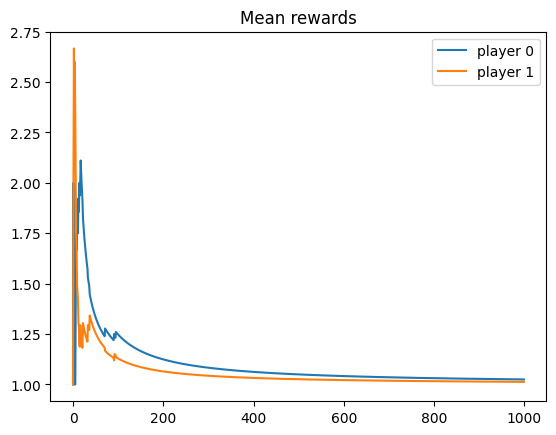

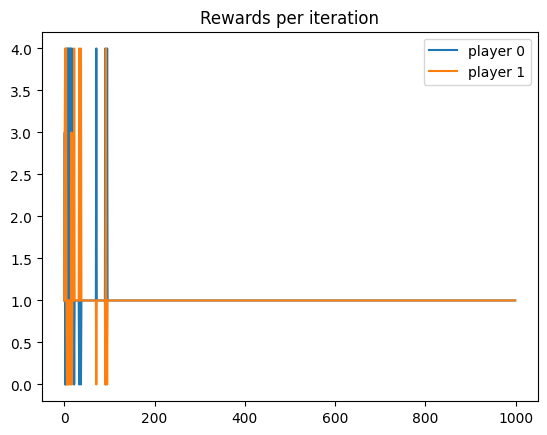

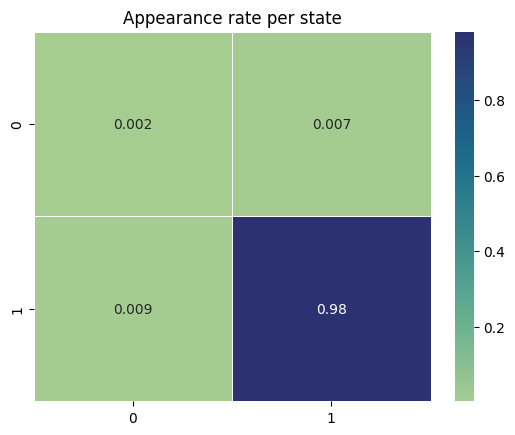

In [16]:
*results_estim, rng_s = simulation_w_estimation()
render_results(*results_estim)

100%|██████████| 1000/1000 [00:03<00:00, 277.37it/s]


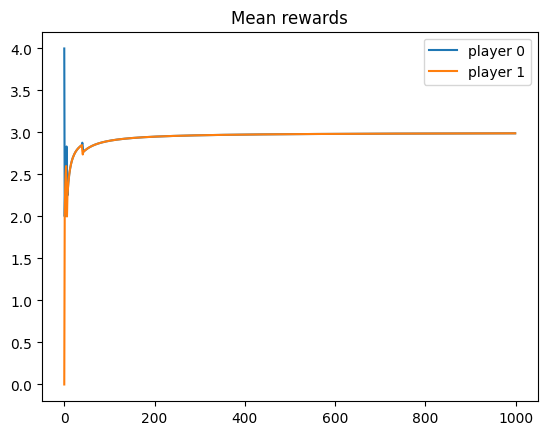

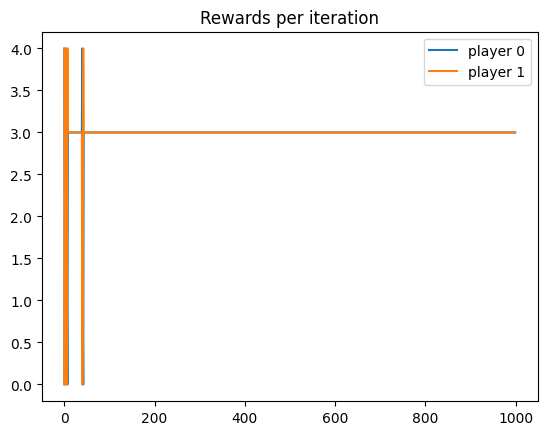

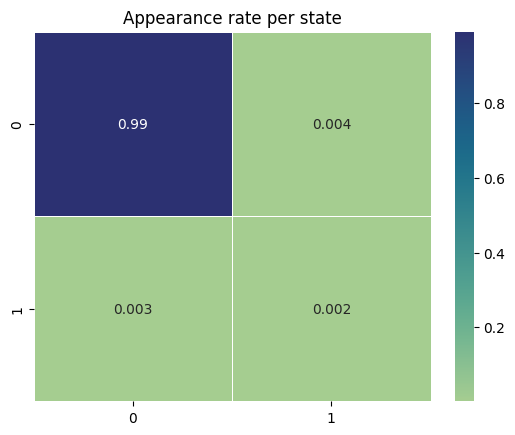

In [22]:
*results_estim, rng_s = simulation_w_estimation(strategy_2=get_strategy(all_strategies[12]))
render_results(*results_estim)

100%|██████████| 1000/1000 [00:03<00:00, 276.68it/s]


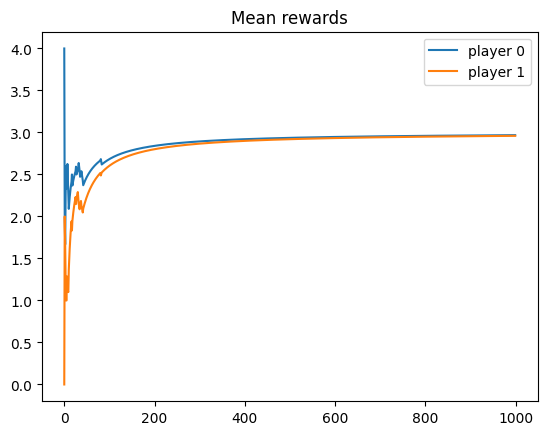

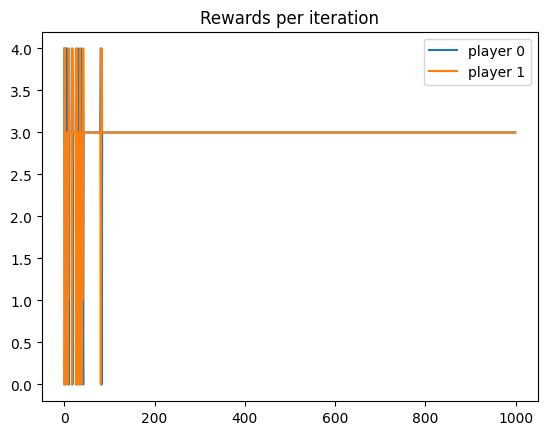

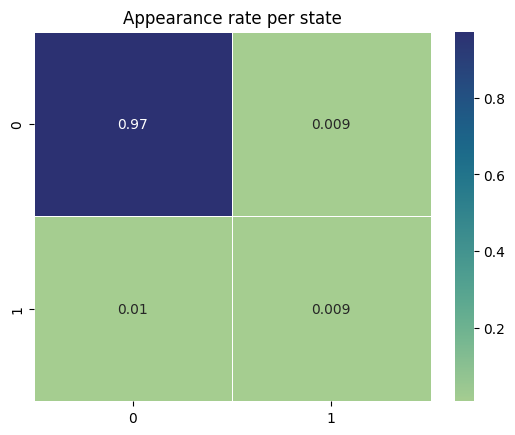

In [19]:
*results_estim, rng_s = simulation_w_estimation(strategy_2=0.8*all_strategies[12] + 0.2*all_strategies[11])
render_results(*results_estim)

100%|██████████| 1000/1000 [00:03<00:00, 284.42it/s]


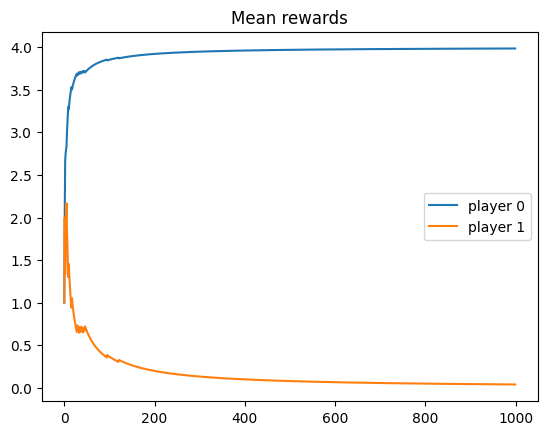

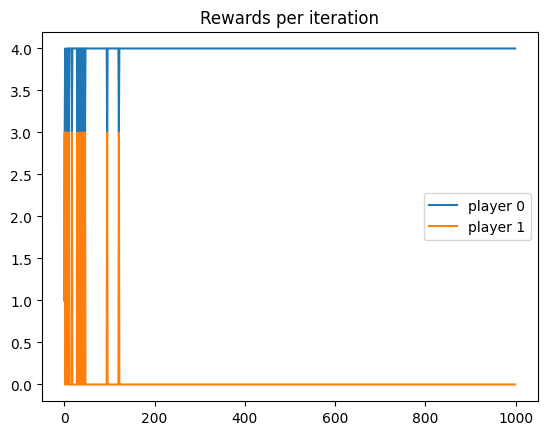

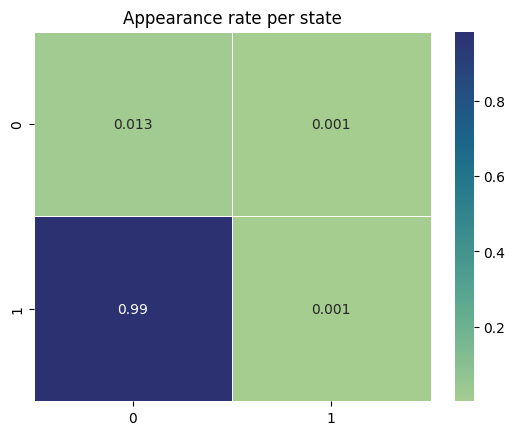

In [24]:
*results_estim, rng_s = simulation_w_estimation(strategy_2=get_strategy(all_strategies[11]))
render_results(*results_estim)

## Other algorithms

In [ ]:
def deterministic_ee(t, means, k):
    #if np.random.random() < 0.05:
    if t == k**2:
        return np.random.randint(0, 2)
    return np.argmin(means)

def tit_for_tat(t, action_1):
    if t == 0:
        return 1
    return action_1[-1]


In [ ]:
def simulate(T=1000):
    means_2 = np.zeros(2)
    means_1 = np.zeros(2)
    actions_1 = []
    actions_2 = []
    
    rewards_1 = []
    rewards_2 = []
    
    k = 0
    for t in range(T):
        i = deterministic_ee(t, means_1, k)
        # j = deterministic_ee(t, means_2, k+1)
        j = tit_for_tat(t, actions_1)
        actions_1.append(i)
        actions_2.append(j)
        rewards_1.append(payouts_1[i, j])
        rewards_2.append(payouts_2[i, j])
        if t == k**2:
            k += 1
        means_1[i] = payouts_1[i, j]/(t+1) + means_1[i]*t/(t+1)
        means_2[j] = payouts_2[i, j]/(t+1) + means_2[j]*t/(t+1)
    
    return means_1, means_2, actions_1, actions_2, rewards_1, rewards_2
    

In [ ]:
means_1, means_2, actions_1, actions_2, rewards_1, rewards_2 = simulate()

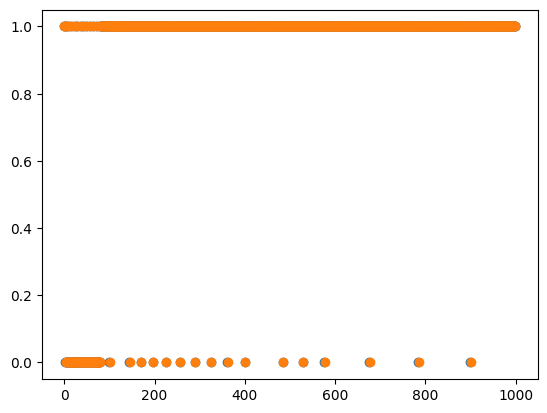

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(range(1000), actions_1)
plt.scatter(range(1000), actions_2)

In [ ]:
np.count_nonzero(actions_2)

917

In [ ]:
means_1

array([2.2002811 , 1.16427358])